## Transfer Learning Using Inception V3 - Flowers Dataset

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

TensorFlow 2.x selected.


In [0]:
from matplotlib import style

import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL.Image as Image
import pandas as pd

In [0]:
style.use('ggplot')

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Load the Flower Dataset from TensorFlow Datasets

In [5]:
splits = tfds.Split.ALL.subsplit(weighted=(70, 30))
splits

(NamedSplitAll()(tfds.percent[0:70]), NamedSplitAll()(tfds.percent[70:100]))

In [6]:
dataset_splits, dataset_info = tfds.load(name='tf_flowers', 
                                         split=splits, 
                                         as_supervised=True, 
                                         with_info=True)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.


In [0]:
training_set, validation_set = dataset_splits

In [8]:
print(training_set)
print(validation_set)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [9]:
dataset_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=1.0.0,
    description='A large set of images of flowers',
    urls=['http://download.tensorflow.org/example_images/flower_photos.tgz'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [10]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
for example_tr in training_set:
  num_training_examples += 1

num_validation_examples = 0
for example_val in validation_set:
  num_validation_examples += 1

print("Number of Flower Classes      : {}".format(num_classes))
print("Number of Training Examples   : {}".format(num_training_examples))
print("Number of Validation Examples : {}".format(num_validation_examples))

Number of Flower Classes      : 5
Number of Training Examples   : 2590
Number of Validation Examples : 1080


In [11]:
for i, example in enumerate(training_set.take(5)):
  print("{} : image_{}_shape : {}".format(i+1, i, example[0].shape))

1 : image_0_shape : (214, 320, 3)
2 : image_1_shape : (213, 320, 3)
3 : image_2_shape : (333, 500, 3)
4 : image_3_shape : (333, 500, 3)
5 : image_4_shape : (333, 500, 3)


### Reformat Images and Create Batches

In [0]:
height = 299
weight = 299

BATCH_SIZE = 32

def format_images(image, label):
  image = tf.image.resize(images=image, size=(height, weight))/255.
  return image, label

In [0]:
training_batches = training_set.shuffle(num_training_examples//4).map(format_images).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_images).batch(BATCH_SIZE).prefetch(1)

In [14]:
image_batch, label_batch = next(iter(training_batches.take(1)))
print(image_batch)
print(label_batch)

tf.Tensor(
[[[[2.35294119e-01 3.80392164e-01 5.84313750e-01]
   [2.35294119e-01 3.80392164e-01 5.84313750e-01]
   [2.33307093e-01 3.78405124e-01 5.82326710e-01]
   ...
   [2.54901975e-01 3.96078438e-01 6.00000024e-01]
   [2.60705680e-01 4.01882142e-01 6.05803728e-01]
   [2.74509817e-01 4.15686280e-01 6.19607866e-01]]

  [[2.35294119e-01 3.80392164e-01 5.84313750e-01]
   [2.35294119e-01 3.80392164e-01 5.84313750e-01]
   [2.33307093e-01 3.78405124e-01 5.82326710e-01]
   ...
   [2.59024769e-01 4.00201231e-01 5.98601162e-01]
   [2.64593005e-01 4.05769467e-01 6.04169369e-01]
   [2.74509817e-01 4.15686280e-01 6.14086211e-01]]

  [[2.35294119e-01 3.80392164e-01 5.84313750e-01]
   [2.33895227e-01 3.78993273e-01 5.82914829e-01]
   [2.32326880e-01 3.77424926e-01 5.81346512e-01]
   ...
   [2.74693787e-01 4.11896199e-01 6.02040112e-01]
   [2.75796860e-01 4.12999332e-01 6.01129711e-01]
   [2.78483838e-01 4.15686280e-01 6.03816628e-01]]

  ...

  [[1.79558367e-01 2.40526140e-01 1.57806277e-01]
   [2

### Simple Transfer Learning with TensorFlow Hub

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor = hub.KerasLayer(handle=URL, input_shape=(height, weight, 3))

In [0]:
feature_batch = feature_extractor(image_batch)

In [17]:
feature_batch

<tf.Tensor: id=22921, shape=(32, 2048), dtype=float32, numpy=
array([[0.45655003, 0.8307509 , 0.88734126, ..., 0.3137842 , 0.86489844,
        0.6075983 ],
       [0.04747051, 0.10656045, 0.06685612, ..., 0.58735657, 0.29596406,
        0.02672176],
       [0.14650351, 0.56105   , 0.14678052, ..., 0.00472511, 0.26626363,
        0.53743505],
       ...,
       [0.16498013, 0.70686674, 0.55720884, ..., 0.02102212, 0.5295898 ,
        0.5226487 ],
       [0.08078921, 0.04085672, 0.09913728, ..., 0.08726408, 0.5184611 ,
        0.21508002],
       [0.02964372, 0.06708084, 0.6798903 , ..., 0.46508104, 0.01960902,
        0.36335933]], dtype=float32)>

### Freezing Variables of Inception V3 Model

In [0]:
feature_extractor.trainable = False

### Attach Classifier Head

In [0]:
model_1 = tf.keras.Sequential([
  feature_extractor, 
  tf.keras.layers.Dense(units=5, activation=tf.nn.softmax)
])

### Compile the Model

In [0]:
model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [21]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


### Fit the Model

In [22]:
EPOCHS = 6

history = model_1.fit(training_batches, 
                      epochs=EPOCHS, 
                      validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 46s 573ms/step - loss: 0.7195 - accuracy: 0.7544 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/6
81/81 [==============================] - 35s 436ms/step - loss: 0.3912 - accuracy: 0.8788 - val_loss: 0.3748 - val_accuracy: 0.8796
Epoch 3/6
81/81 [==============================] - 35s 434ms/step - loss: 0.3133 - accuracy: 0.9081 - val_loss: 0.3305 - val_accuracy: 0.8935
Epoch 4/6
81/81 [==============================] - 35s 433ms/step - loss: 0.2603 - accuracy: 0.9174 - val_loss: 0.3225 - val_accuracy: 0.8944
Epoch 5/6
81/81 [==============================] - 35s 433ms/step - loss: 0.2383 - accuracy: 0.9305 - val_loss: 0.2936 - val_accuracy: 0.9102
Epoch 6/6
81/81 [==============================] - 35s 433ms/step - loss: 0.2071 - accuracy: 0.9378 - val_loss: 0.2904 - val_accuracy: 0.9102


### Plot the Training & Validation Graphs

In [23]:
data = {
    'train_acc' : history.history['accuracy'], 
    'train_loss' : history.history['loss'], 
    'val_acc' : history.history['val_accuracy'], 
    'val_loss' : history.history['val_loss']
}

history_df = pd.DataFrame(data=data, index=history.epoch)
display(history_df)

,train_acc,train_loss,val_acc,val_loss
0,0.754440,0.719738,0.851852,0.447413
1,0.878764,0.378133,0.879630,0.374837
2,0.908108,0.303982,0.893519,0.330500
3,0.917374,0.259039,0.894444,0.322494
4,0.930502,0.232040,0.910185,0.293575
5,0.937838,0.201656,0.910185,0.290376


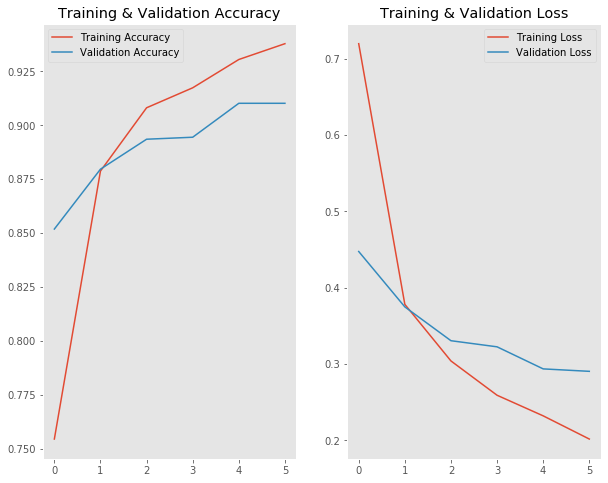

In [24]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Training & Validation Accuracy")
plt.plot(history_df.index, history_df['train_acc'], label="Training Accuracy")
plt.plot(history_df.index, history_df['val_acc'], label="Validation Accuracy")
plt.grid(False)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Training & Validation Loss")
plt.plot(history_df.index, history_df['train_loss'], label="Training Loss")
plt.plot(history_df.index, history_df['val_loss'], label="Validation Loss")
plt.grid(False)
plt.legend()

plt.savefig('./foo.png')
plt.show()

### Check Predictions

In [0]:
predicted_batch = model_1.predict(image_batch)

In [26]:
print(predicted_batch)
print(predicted_batch.shape)

[[1.4803240e-03 6.6368765e-04 9.4330078e-01 3.0936616e-02 2.3618644e-02]
 [9.5222825e-01 1.1287873e-03 2.1936899e-02 2.0341601e-02 4.3644891e-03]
 [7.9978202e-03 9.9170166e-01 9.9028948e-05 1.6158965e-04 3.9802679e-05]
 [9.9034552e-03 9.7852957e-01 6.9324794e-04 1.0830538e-02 4.3132623e-05]
 [6.5052414e-01 3.4138721e-03 5.6660073e-03 3.4025156e-01 1.4441855e-04]
 [3.1465285e-03 1.2314757e-03 9.2386901e-01 4.4403495e-03 6.7312524e-02]
 [7.4078655e-04 9.9719965e-01 4.7790725e-04 1.5569800e-03 2.4587081e-05]
 [9.9971813e-01 6.6137094e-05 1.9659978e-04 1.8334911e-05 6.6748993e-07]
 [2.8607994e-03 9.0405939e-04 9.5991480e-01 1.2338980e-02 2.3981418e-02]
 [2.6372394e-03 9.9365354e-01 5.1572436e-04 3.1034558e-03 9.0060654e-05]
 [4.5347433e-03 2.1794881e-04 2.3417795e-02 9.6939433e-01 2.4352595e-03]
 [3.7351332e-03 1.2806325e-02 1.2456850e-03 9.8200190e-01 2.1094075e-04]
 [1.8021393e-04 3.9280098e-04 1.5663281e-05 9.9923790e-01 1.7351296e-04]
 [7.3255077e-02 8.5948467e-01 2.1645632e-02 3.77018

In [0]:
predicted_ids = np.argmax(predicted_batch, axis=-1)

In [28]:
print(predicted_ids)
print(predicted_ids.shape)

[2 0 1 1 0 2 1 0 2 1 3 3 3 1 2 3 0 0 4 3 0 0 0 0 4 3 2 1 4 0 4 1]
(32,)


In [29]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [30]:
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['tulips', 'dandelion', 'daisy', 'daisy', 'dandelion', 'tulips',
       'daisy', 'dandelion', 'tulips', 'daisy', 'sunflowers',
       'sunflowers', 'sunflowers', 'daisy', 'tulips', 'sunflowers',
       'dandelion', 'dandelion', 'roses', 'sunflowers', 'dandelion',
       'dandelion', 'dandelion', 'dandelion', 'roses', 'sunflowers',
       'tulips', 'daisy', 'roses', 'dandelion', 'roses', 'daisy'],
      dtype='<U10')

In [31]:
print("True Labels      : {}".format(label_batch))
print("Predicted Labels : {}".format(predicted_ids))

True Labels      : [2 0 1 1 0 2 1 0 2 1 3 3 3 1 2 3 0 0 4 3 0 1 0 0 4 3 2 1 4 0 4 1]
Predicted Labels : [2 0 1 1 0 2 1 0 2 1 3 3 3 1 2 3 0 0 4 3 0 0 0 0 4 3 2 1 4 0 4 1]


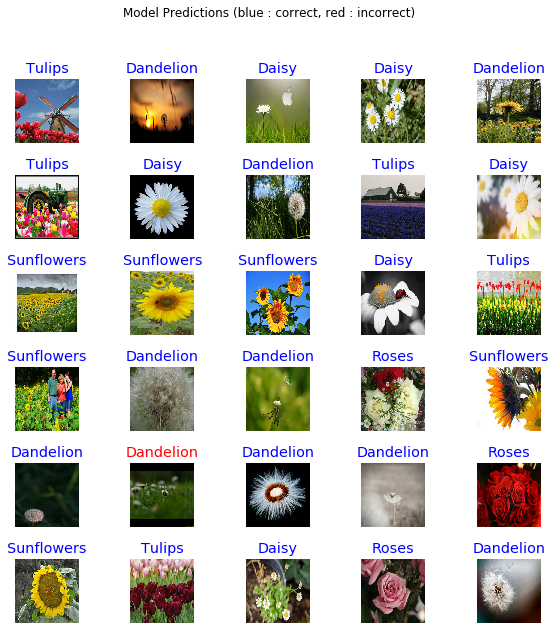

In [33]:
plt.figure(figsize=(10, 10))
plt.suptitle("Model Predictions (blue : correct, red : incorrect)")

for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.subplots_adjust(hspace=0.5)
  plt.imshow(image_batch[n])
  color = 'blue' if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.grid(False)
  plt.axis('off')

plt.show()